<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
!pip install opencv-python

In [2]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
# import sys
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
!cp '/content/gdrive/MyDrive/Image Captioning/beheaded_inception3.py' ./
!cp '/content/gdrive/MyDrive/Image Captioning/handout.tar' ./
!tar -xf /content/handout.tar

In [4]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("./data/image_codes.npy")
captions = json.load(open('./data/captions_tokenized.json'))

In [5]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [6]:
import copy
START = "<START>"
END = "<END>"
PAD = "<PAD>"
UNK = "<UNK>"
captions_processed = copy.deepcopy(captions)
for img_captions in range(len(captions)):
    for caption in range(len(captions[img_captions])):
        sentence = captions[img_captions][caption] 
        captions_processed[img_captions][caption] = [START]+sentence.split(' ')+[END]

In [7]:
from collections import Counter
word_counts = Counter()

for img_captions in range(len(captions_processed)):
    for caption in range(len(captions_processed[img_captions])):
        for word in captions_processed[img_captions][caption][1:-1]:
          word_counts[word] += 1

In [8]:
vocab = []
vocab = [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
vocab += [UNK, START, END, PAD]
tokens_length = len(vocab)

word_to_index = {w: i for i, w in enumerate(vocab)}

In [9]:
len(vocab)

10403

In [10]:
eos_ix = word_to_index[END]
unk_ix = word_to_index[UNK]
pad_ix = word_to_index[PAD]

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [11]:
as_matrix(captions_processed[2545])

array([[10400,    20,   117,   118,    54,    20,   439,  3305,  1658,
        10401, 10402, 10402, 10402, 10402],
       [10400,    20,   127,    43,   117,    54,    20,  4806,   326,
          118,     8, 10401, 10402, 10402],
       [10400,  3698,    11,   769,   118,   137,    10,    20,   117,
        10401, 10402, 10402, 10402, 10402],
       [10400,    20,    43,   118,   136,     2,    20,   117,   370,
           20,  3601,    98,     8, 10401],
       [10400,    41,   117,    37,   769,    11,   620,   113,   512,
         1853,     8, 10401, 10402, 10402]], dtype=int32)

In [12]:
from random import choice
import torch, torch.nn as nn
import torch.nn.functional as F

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    batch_images = img_codes[random_image_ix]
    captions_for_batch_images = captions[random_image_ix]
    
    batch_captions = list(map(choice,captions_for_batch_images))
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [13]:
from sklearn.model_selection import train_test_split

captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions, test_size=0.15, random_state=24)

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [14]:
class CaptionNet(nn.Module):
    def __init__(self, cnn_feature_size=2048, lstm_feature_size=256, emb_size=128, tokens_size=0):
        super(self.__class__, self).__init__()

        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        self.cnn_h0 = nn.Linear(cnn_feature_size, lstm_feature_size)
        self.cnn_c0 = nn.Linear(cnn_feature_size, lstm_feature_size)

        # 2. слой эмбедднга
        self.emb = nn.Embedding(tokens_size, emb_size, padding_idx = pad_ix)

        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=lstm_feature_size, batch_first = True, num_layers=1)

        # 4. линейный слой для получения логитов
        self.logits = nn.Linear(lstm_feature_size, tokens_size)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """
        
        # 1. инициализируем LSTM state
        initial_cell = self.cnn_c0(image_vectors)
        initial_hid = self.cnn_h0(image_vectors)
        # 2. применим слой эмбеддингов к image_vectors
        captions_emb = self.emb(captions_ix)
        # 3. скормим LSTM captions_emb
        lstm_out, _ = self.lstm(captions_emb, (initial_cell.unsqueeze(0), initial_hid.unsqueeze(0)))
        # 4. посчитаем логиты из выхода LSTM
        logits = self.logits(lstm_out)
        
        return logits        

In [15]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """

    image_vectors = image_vectors.to(device)
    captions_ix = captions_ix.to(device)
    
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    mask = captions_ix_next != pad_ix 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    logits_for_next = network(image_vectors.to(device), captions_ix_inp)
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    next_reshaped = captions_ix_next.view(-1)
    logits_reshaped = logits_for_next.view(-1, logits_for_next.size()[-1])
    
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    cross_entropy = nn.CrossEntropyLoss(reduction = 'none').to(device)
    loss = cross_entropy(logits_reshaped, next_reshaped).view(captions_ix_next.size()[0], captions_ix_next.size()[1]) * mask.float()
    
    return loss.mean(dim = -1).mean(dim = -1).view(-1)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = CaptionNet(tokens_size=tokens_length).to(device)

optimizer = torch.optim.Adam(network.parameters(), lr=1e-3) # favourite one

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [17]:
batch_size = 128
n_epochs = 200
n_batches_per_epoch = 300
n_validation_batches = 10

In [ ]:
# network.load_state_dict(torch.load('./'))

In [18]:
from tqdm import tqdm

for epoch in range(n_epochs):
    network.train()
    train_loss = 0
    for _ in tqdm(range(n_batches_per_epoch)):
        
        img_batch, captions_batch = generate_batch(train_img_codes, train_captions, batch_size)
        loss_t = compute_loss(network, img_batch, captions_batch)
      
        loss_t.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss_t.cpu().data.numpy()[0]
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.eval()
    with torch.no_grad():
      for _ in range(n_validation_batches):
          loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
          val_loss += loss_t.cpu().data.numpy()[0]
      val_loss /= n_validation_batches
      print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch + 1, train_loss, val_loss))

100%|██████████| 300/300 [00:27<00:00, 10.81it/s]



Epoch: 1, train loss: 1.2507879012823104, val loss: 0.8334217727184295


100%|██████████| 300/300 [00:29<00:00, 10.30it/s]



Epoch: 2, train loss: 0.8697737540801366, val loss: 0.8160378873348236


100%|██████████| 300/300 [00:28<00:00, 10.47it/s]



Epoch: 3, train loss: 0.7724815098444621, val loss: 0.6294618308544159


100%|██████████| 300/300 [00:28<00:00, 10.45it/s]



Epoch: 4, train loss: 0.7051422225435575, val loss: 0.6615752309560776


100%|██████████| 300/300 [00:29<00:00, 10.19it/s]



Epoch: 5, train loss: 0.647975865205129, val loss: 0.6211148619651794


100%|██████████| 300/300 [00:29<00:00, 10.20it/s]



Epoch: 6, train loss: 0.6155139033993086, val loss: 0.5749154090881348


100%|██████████| 300/300 [00:30<00:00,  9.95it/s]



Epoch: 7, train loss: 0.5878141421079636, val loss: 0.5797051668167115


100%|██████████| 300/300 [00:29<00:00, 10.21it/s]



Epoch: 8, train loss: 0.5735890223582586, val loss: 0.6313825100660324


100%|██████████| 300/300 [00:29<00:00, 10.08it/s]



Epoch: 9, train loss: 0.5549841807285945, val loss: 0.5587321788072586


100%|██████████| 300/300 [00:29<00:00, 10.07it/s]



Epoch: 10, train loss: 0.5369602791468302, val loss: 0.5528934895992279


100%|██████████| 300/300 [00:29<00:00, 10.09it/s]



Epoch: 11, train loss: 0.5233096177875995, val loss: 0.52865449488163


100%|██████████| 300/300 [00:30<00:00,  9.98it/s]



Epoch: 12, train loss: 0.5125777241090933, val loss: 0.44159899950027465


100%|██████████| 300/300 [00:29<00:00, 10.11it/s]



Epoch: 13, train loss: 0.5033691977461179, val loss: 0.5056002527475357


100%|██████████| 300/300 [00:30<00:00,  9.87it/s]



Epoch: 14, train loss: 0.4916920047998428, val loss: 0.5403404742479324


100%|██████████| 300/300 [00:30<00:00,  9.79it/s]



Epoch: 15, train loss: 0.4852036256094774, val loss: 0.5564077913761138


100%|██████████| 300/300 [00:29<00:00, 10.24it/s]



Epoch: 16, train loss: 0.4940108689169089, val loss: 0.43055268824100495


100%|██████████| 300/300 [00:29<00:00, 10.23it/s]



Epoch: 17, train loss: 0.4856796446442604, val loss: 0.4601495355367661


100%|██████████| 300/300 [00:30<00:00,  9.94it/s]



Epoch: 18, train loss: 0.47366417199373245, val loss: 0.4949633330106735


100%|██████████| 300/300 [00:29<00:00, 10.03it/s]



Epoch: 19, train loss: 0.4721860884130001, val loss: 0.5057175487279892


100%|██████████| 300/300 [00:29<00:00, 10.14it/s]



Epoch: 20, train loss: 0.47112577517827353, val loss: 0.49445545077323916


100%|██████████| 300/300 [00:30<00:00,  9.94it/s]



Epoch: 21, train loss: 0.46081228638688726, val loss: 0.46519988477230073


100%|██████████| 300/300 [00:30<00:00,  9.93it/s]



Epoch: 22, train loss: 0.4560136650502682, val loss: 0.43270183354616165


100%|██████████| 300/300 [00:29<00:00, 10.33it/s]



Epoch: 23, train loss: 0.46911851276954014, val loss: 0.4836567223072052


100%|██████████| 300/300 [00:30<00:00,  9.83it/s]



Epoch: 24, train loss: 0.44913517554601035, val loss: 0.4676882982254028


100%|██████████| 300/300 [00:29<00:00, 10.02it/s]



Epoch: 25, train loss: 0.45404063115517296, val loss: 0.4277577012777328


100%|██████████| 300/300 [00:29<00:00, 10.27it/s]



Epoch: 26, train loss: 0.45864663243293763, val loss: 0.4361457496881485


100%|██████████| 300/300 [00:29<00:00, 10.13it/s]



Epoch: 27, train loss: 0.45634084711472195, val loss: 0.46873435378074646


100%|██████████| 300/300 [00:29<00:00, 10.04it/s]



Epoch: 28, train loss: 0.445982126891613, val loss: 0.45566719174385073


100%|██████████| 300/300 [00:30<00:00,  9.90it/s]



Epoch: 29, train loss: 0.4419183254738649, val loss: 0.4465249925851822


100%|██████████| 300/300 [00:30<00:00,  9.85it/s]



Epoch: 30, train loss: 0.43606619169314703, val loss: 0.42142349779605864


100%|██████████| 300/300 [00:30<00:00,  9.81it/s]



Epoch: 31, train loss: 0.4361750365793705, val loss: 0.4900379300117493


100%|██████████| 300/300 [00:31<00:00,  9.64it/s]



Epoch: 32, train loss: 0.4295610439777374, val loss: 0.46233755350112915


100%|██████████| 300/300 [00:30<00:00,  9.94it/s]



Epoch: 33, train loss: 0.4352835116783778, val loss: 0.4120555013418198


100%|██████████| 300/300 [00:31<00:00,  9.65it/s]



Epoch: 34, train loss: 0.4215473997096221, val loss: 0.42453798949718474


100%|██████████| 300/300 [00:30<00:00,  9.92it/s]



Epoch: 35, train loss: 0.4301647886633873, val loss: 0.4484302818775177


100%|██████████| 300/300 [00:30<00:00,  9.96it/s]



Epoch: 36, train loss: 0.43122286041577657, val loss: 0.36709338128566743


100%|██████████| 300/300 [00:30<00:00,  9.97it/s]



Epoch: 37, train loss: 0.42682237113515537, val loss: 0.44666113555431364


100%|██████████| 300/300 [00:29<00:00, 10.27it/s]



Epoch: 38, train loss: 0.4369939099252224, val loss: 0.4195866584777832


100%|██████████| 300/300 [00:30<00:00,  9.89it/s]



Epoch: 39, train loss: 0.4232643488546213, val loss: 0.47839836180210116


100%|██████████| 300/300 [00:29<00:00, 10.17it/s]



Epoch: 40, train loss: 0.43179286087552704, val loss: 0.4788677513599396


100%|██████████| 300/300 [00:30<00:00,  9.84it/s]



Epoch: 41, train loss: 0.42023629541198415, val loss: 0.4259908854961395


100%|██████████| 300/300 [00:30<00:00,  9.99it/s]



Epoch: 42, train loss: 0.42287082701921463, val loss: 0.43992916494607925


100%|██████████| 300/300 [00:30<00:00,  9.94it/s]



Epoch: 43, train loss: 0.41816706930597625, val loss: 0.3862319141626358


100%|██████████| 300/300 [00:30<00:00,  9.90it/s]



Epoch: 44, train loss: 0.41620725139975545, val loss: 0.4082074135541916


100%|██████████| 300/300 [00:29<00:00, 10.06it/s]



Epoch: 45, train loss: 0.42434071496129033, val loss: 0.3956893444061279


100%|██████████| 300/300 [00:29<00:00, 10.07it/s]



Epoch: 46, train loss: 0.4234015016257763, val loss: 0.4016728013753891


100%|██████████| 300/300 [00:29<00:00, 10.09it/s]



Epoch: 47, train loss: 0.42120016664266585, val loss: 0.41331351101398467


100%|██████████| 300/300 [00:30<00:00,  9.87it/s]



Epoch: 48, train loss: 0.410631136794885, val loss: 0.4208552181720734


100%|██████████| 300/300 [00:30<00:00,  9.84it/s]



Epoch: 49, train loss: 0.4080455938975016, val loss: 0.3815036788582802


100%|██████████| 300/300 [00:29<00:00, 10.18it/s]



Epoch: 50, train loss: 0.418976363192002, val loss: 0.3608398035168648


100%|██████████| 300/300 [00:29<00:00, 10.26it/s]



Epoch: 51, train loss: 0.41793280879656475, val loss: 0.4301708906888962


100%|██████████| 300/300 [00:29<00:00, 10.16it/s]



Epoch: 52, train loss: 0.4142690312862396, val loss: 0.3833148956298828


100%|██████████| 300/300 [00:30<00:00,  9.85it/s]



Epoch: 53, train loss: 0.40812349364161493, val loss: 0.37115027457475663


100%|██████████| 300/300 [00:29<00:00, 10.07it/s]



Epoch: 54, train loss: 0.4119567867120107, val loss: 0.40121195614337923


100%|██████████| 300/300 [00:29<00:00, 10.26it/s]



Epoch: 55, train loss: 0.41714767217636106, val loss: 0.41219794750213623


100%|██████████| 300/300 [00:30<00:00,  9.83it/s]



Epoch: 56, train loss: 0.40394359494249027, val loss: 0.42771402895450594


100%|██████████| 300/300 [00:29<00:00, 10.13it/s]



Epoch: 57, train loss: 0.41274862582484884, val loss: 0.4259937673807144


100%|██████████| 300/300 [00:30<00:00,  9.84it/s]



Epoch: 58, train loss: 0.4058191631237666, val loss: 0.39289489984512327


100%|██████████| 300/300 [00:30<00:00,  9.86it/s]



Epoch: 59, train loss: 0.40052238682905833, val loss: 0.38341071307659147


100%|██████████| 300/300 [00:30<00:00,  9.82it/s]



Epoch: 60, train loss: 0.4003861953318119, val loss: 0.374832321703434


100%|██████████| 300/300 [00:29<00:00, 10.34it/s]



Epoch: 61, train loss: 0.4170487080017726, val loss: 0.4313235193490982


100%|██████████| 300/300 [00:29<00:00, 10.07it/s]



Epoch: 62, train loss: 0.4028645284473896, val loss: 0.3482911467552185


100%|██████████| 300/300 [00:30<00:00,  9.91it/s]



Epoch: 63, train loss: 0.3991233176986376, val loss: 0.4159472197294235


100%|██████████| 300/300 [00:29<00:00, 10.09it/s]



Epoch: 64, train loss: 0.4047158800562223, val loss: 0.3976248264312744


100%|██████████| 300/300 [00:29<00:00, 10.01it/s]



Epoch: 65, train loss: 0.4005293095111847, val loss: 0.4051225930452347


100%|██████████| 300/300 [00:29<00:00, 10.02it/s]



Epoch: 66, train loss: 0.4033419268329938, val loss: 0.40823263227939605


100%|██████████| 300/300 [00:29<00:00, 10.05it/s]



Epoch: 67, train loss: 0.40371427237987517, val loss: 0.4121133595705032


100%|██████████| 300/300 [00:30<00:00, 10.00it/s]



Epoch: 68, train loss: 0.3974939323961735, val loss: 0.3670595228672028


100%|██████████| 300/300 [00:30<00:00,  9.96it/s]



Epoch: 69, train loss: 0.39766449431578316, val loss: 0.3740238189697266


100%|██████████| 300/300 [00:30<00:00,  9.85it/s]



Epoch: 70, train loss: 0.39375673164923986, val loss: 0.34737908840179443


100%|██████████| 300/300 [00:29<00:00, 10.19it/s]



Epoch: 71, train loss: 0.4035817684233189, val loss: 0.42011651694774627


100%|██████████| 300/300 [00:29<00:00, 10.21it/s]



Epoch: 72, train loss: 0.4029954751829306, val loss: 0.3816265881061554


100%|██████████| 300/300 [00:30<00:00,  9.82it/s]



Epoch: 73, train loss: 0.3953349330027898, val loss: 0.40622179955244064


100%|██████████| 300/300 [00:31<00:00,  9.54it/s]



Epoch: 74, train loss: 0.38531203965346017, val loss: 0.400860059261322


100%|██████████| 300/300 [00:30<00:00,  9.95it/s]



Epoch: 75, train loss: 0.39849490851163866, val loss: 0.4044066399335861


100%|██████████| 300/300 [00:30<00:00,  9.91it/s]



Epoch: 76, train loss: 0.39475120380520823, val loss: 0.358061720430851


100%|██████████| 300/300 [00:30<00:00,  9.92it/s]



Epoch: 77, train loss: 0.3955872783064842, val loss: 0.3692208379507065


100%|██████████| 300/300 [00:30<00:00,  9.90it/s]



Epoch: 78, train loss: 0.3904662746191025, val loss: 0.3365548476576805


100%|██████████| 300/300 [00:30<00:00,  9.97it/s]



Epoch: 79, train loss: 0.39295917222897214, val loss: 0.3850617051124573


100%|██████████| 300/300 [00:29<00:00, 10.06it/s]



Epoch: 80, train loss: 0.3952480100095272, val loss: 0.32600860446691515


100%|██████████| 300/300 [00:29<00:00, 10.08it/s]



Epoch: 81, train loss: 0.3954762382308642, val loss: 0.3740364134311676


100%|██████████| 300/300 [00:30<00:00,  9.86it/s]



Epoch: 82, train loss: 0.3893540334701538, val loss: 0.3499936580657959


100%|██████████| 300/300 [00:29<00:00, 10.13it/s]



Epoch: 83, train loss: 0.3946592153608799, val loss: 0.38464063555002215


100%|██████████| 300/300 [00:30<00:00,  9.99it/s]



Epoch: 84, train loss: 0.3877995668848356, val loss: 0.39029626846313475


100%|██████████| 300/300 [00:30<00:00,  9.92it/s]



Epoch: 85, train loss: 0.3886375891168912, val loss: 0.40262762904167176


100%|██████████| 300/300 [00:29<00:00, 10.25it/s]



Epoch: 86, train loss: 0.39790670946240425, val loss: 0.4352808028459549


100%|██████████| 300/300 [00:30<00:00,  9.96it/s]



Epoch: 87, train loss: 0.3873843248685201, val loss: 0.406050506234169


100%|██████████| 300/300 [00:31<00:00,  9.67it/s]



Epoch: 88, train loss: 0.3814287978410721, val loss: 0.41318253576755526


100%|██████████| 300/300 [00:30<00:00,  9.88it/s]



Epoch: 89, train loss: 0.3860439398388068, val loss: 0.3627637580037117


100%|██████████| 300/300 [00:30<00:00,  9.79it/s]



Epoch: 90, train loss: 0.3840315495928129, val loss: 0.41629883646965027


100%|██████████| 300/300 [00:30<00:00,  9.97it/s]



Epoch: 91, train loss: 0.3873521236081918, val loss: 0.37756663262844087


100%|██████████| 300/300 [00:29<00:00, 10.17it/s]



Epoch: 92, train loss: 0.39329642698168754, val loss: 0.3447810232639313


100%|██████████| 300/300 [00:30<00:00,  9.79it/s]



Epoch: 93, train loss: 0.3814268764356772, val loss: 0.40429332554340364


100%|██████████| 300/300 [00:29<00:00, 10.02it/s]



Epoch: 94, train loss: 0.38739441658059753, val loss: 0.3547498881816864


100%|██████████| 300/300 [00:31<00:00,  9.59it/s]



Epoch: 95, train loss: 0.37988540341456734, val loss: 0.39416315853595735


100%|██████████| 300/300 [00:30<00:00,  9.81it/s]



Epoch: 96, train loss: 0.38244112675388653, val loss: 0.3899823933839798


100%|██████████| 300/300 [00:29<00:00, 10.12it/s]



Epoch: 97, train loss: 0.39588688959678014, val loss: 0.3918746054172516


100%|██████████| 300/300 [00:30<00:00,  9.90it/s]



Epoch: 98, train loss: 0.38414774000644686, val loss: 0.40721520483493806


100%|██████████| 300/300 [00:30<00:00,  9.90it/s]



Epoch: 99, train loss: 0.3852065353095531, val loss: 0.38083629608154296


100%|██████████| 300/300 [00:31<00:00,  9.65it/s]



Epoch: 100, train loss: 0.37805138235290847, val loss: 0.3006088986992836


100%|██████████| 300/300 [00:29<00:00, 10.16it/s]



Epoch: 101, train loss: 0.3882981276015441, val loss: 0.3662466615438461


100%|██████████| 300/300 [00:30<00:00,  9.74it/s]



Epoch: 102, train loss: 0.3795594237744808, val loss: 0.4077449649572372


100%|██████████| 300/300 [00:30<00:00,  9.95it/s]



Epoch: 103, train loss: 0.3842415177325408, val loss: 0.37867447435855867


100%|██████████| 300/300 [00:30<00:00,  9.95it/s]



Epoch: 104, train loss: 0.382007964849472, val loss: 0.3805465668439865


100%|██████████| 300/300 [00:30<00:00,  9.90it/s]



Epoch: 105, train loss: 0.38197316000858944, val loss: 0.3546963334083557


100%|██████████| 300/300 [00:30<00:00,  9.76it/s]



Epoch: 106, train loss: 0.3777884183327357, val loss: 0.3554217144846916


100%|██████████| 300/300 [00:30<00:00,  9.79it/s]



Epoch: 107, train loss: 0.3789207291106383, val loss: 0.37502129673957824


100%|██████████| 300/300 [00:30<00:00,  9.88it/s]



Epoch: 108, train loss: 0.3798468809823195, val loss: 0.389851388335228


100%|██████████| 300/300 [00:30<00:00,  9.77it/s]



Epoch: 109, train loss: 0.37574022725224493, val loss: 0.41987191140651703


100%|██████████| 300/300 [00:30<00:00,  9.98it/s]



Epoch: 110, train loss: 0.3825664980709553, val loss: 0.3922272354364395


100%|██████████| 300/300 [00:30<00:00,  9.78it/s]



Epoch: 111, train loss: 0.3795805724461873, val loss: 0.38590321093797686


100%|██████████| 300/300 [00:30<00:00,  9.85it/s]



Epoch: 112, train loss: 0.3767449938754241, val loss: 0.3512097030878067


100%|██████████| 300/300 [00:29<00:00, 10.11it/s]



Epoch: 113, train loss: 0.3844003963470459, val loss: 0.4126692622900009


100%|██████████| 300/300 [00:30<00:00,  9.91it/s]



Epoch: 114, train loss: 0.3791632678111394, val loss: 0.36232799738645555


100%|██████████| 300/300 [00:30<00:00,  9.87it/s]



Epoch: 115, train loss: 0.37783809373776117, val loss: 0.35162046253681184


100%|██████████| 300/300 [00:30<00:00,  9.88it/s]



Epoch: 116, train loss: 0.37852164179086684, val loss: 0.398680554330349


100%|██████████| 300/300 [00:29<00:00, 10.02it/s]



Epoch: 117, train loss: 0.3827860932548841, val loss: 0.3502949446439743


100%|██████████| 300/300 [00:30<00:00,  9.95it/s]



Epoch: 118, train loss: 0.3803305357694626, val loss: 0.39209417402744295


100%|██████████| 300/300 [00:30<00:00,  9.95it/s]



Epoch: 119, train loss: 0.37937030668059984, val loss: 0.387527334690094


100%|██████████| 300/300 [00:30<00:00,  9.81it/s]



Epoch: 120, train loss: 0.37416203409433363, val loss: 0.36517115831375124


100%|██████████| 300/300 [00:29<00:00, 10.28it/s]



Epoch: 121, train loss: 0.3879977611700694, val loss: 0.3613723814487457


100%|██████████| 300/300 [00:30<00:00,  9.86it/s]



Epoch: 122, train loss: 0.3769279925028483, val loss: 0.413291671872139


100%|██████████| 300/300 [00:30<00:00,  9.82it/s]



Epoch: 123, train loss: 0.37575220232208567, val loss: 0.3699500173330307


100%|██████████| 300/300 [00:30<00:00,  9.90it/s]



Epoch: 124, train loss: 0.3759723021586736, val loss: 0.37433581054210663


100%|██████████| 300/300 [00:29<00:00, 10.11it/s]



Epoch: 125, train loss: 0.3799633553624153, val loss: 0.3671049803495407


100%|██████████| 300/300 [00:29<00:00, 10.12it/s]



Epoch: 126, train loss: 0.3812098302443822, val loss: 0.41287596225738527


100%|██████████| 300/300 [00:30<00:00,  9.94it/s]



Epoch: 127, train loss: 0.37744871507088346, val loss: 0.37020440995693205


100%|██████████| 300/300 [00:30<00:00,  9.90it/s]



Epoch: 128, train loss: 0.37313756664594017, val loss: 0.3614488482475281


100%|██████████| 300/300 [00:30<00:00,  9.85it/s]



Epoch: 129, train loss: 0.374428082605203, val loss: 0.37934652268886565


100%|██████████| 300/300 [00:30<00:00,  9.95it/s]



Epoch: 130, train loss: 0.3767480736970901, val loss: 0.3959401875734329


100%|██████████| 300/300 [00:30<00:00,  9.99it/s]



Epoch: 131, train loss: 0.37626761173208556, val loss: 0.34884963035583494


100%|██████████| 300/300 [00:30<00:00,  9.82it/s]



Epoch: 132, train loss: 0.3728133185704549, val loss: 0.398993581533432


100%|██████████| 300/300 [00:29<00:00, 10.18it/s]



Epoch: 133, train loss: 0.3827346635858218, val loss: 0.3561739981174469


100%|██████████| 300/300 [00:29<00:00, 10.13it/s]



Epoch: 134, train loss: 0.38013757651050883, val loss: 0.39301466941833496


100%|██████████| 300/300 [00:29<00:00, 10.10it/s]



Epoch: 135, train loss: 0.37718032280604047, val loss: 0.3696290925145149


100%|██████████| 300/300 [00:30<00:00,  9.86it/s]



Epoch: 136, train loss: 0.372235922763745, val loss: 0.4128560245037079


100%|██████████| 300/300 [00:28<00:00, 10.35it/s]



Epoch: 137, train loss: 0.38772631660103796, val loss: 0.4115801006555557


100%|██████████| 300/300 [00:29<00:00, 10.02it/s]



Epoch: 138, train loss: 0.3799470103283723, val loss: 0.3435350403189659


100%|██████████| 300/300 [00:30<00:00,  9.91it/s]



Epoch: 139, train loss: 0.3750857042769591, val loss: 0.3556218326091766


100%|██████████| 300/300 [00:30<00:00,  9.84it/s]



Epoch: 140, train loss: 0.3718516459067663, val loss: 0.3846766024827957


100%|██████████| 300/300 [00:30<00:00,  9.79it/s]



Epoch: 141, train loss: 0.36794055794676145, val loss: 0.3933043360710144


100%|██████████| 300/300 [00:29<00:00, 10.15it/s]



Epoch: 142, train loss: 0.3804135743280252, val loss: 0.3407602563500404


100%|██████████| 300/300 [00:30<00:00,  9.98it/s]



Epoch: 143, train loss: 0.37305730938911436, val loss: 0.3560785263776779


100%|██████████| 300/300 [00:30<00:00,  9.83it/s]



Epoch: 144, train loss: 0.3700185522933801, val loss: 0.37793363630771637


100%|██████████| 300/300 [00:30<00:00,  9.75it/s]



Epoch: 145, train loss: 0.3675628866751989, val loss: 0.33027779012918473


100%|██████████| 300/300 [00:30<00:00,  9.92it/s]



Epoch: 146, train loss: 0.37110278869668645, val loss: 0.3237299367785454


100%|██████████| 300/300 [00:29<00:00, 10.10it/s]



Epoch: 147, train loss: 0.3797695489724477, val loss: 0.3740693017840385


100%|██████████| 300/300 [00:29<00:00, 10.01it/s]



Epoch: 148, train loss: 0.3765238278110822, val loss: 0.4002204418182373


100%|██████████| 300/300 [00:30<00:00,  9.96it/s]



Epoch: 149, train loss: 0.373220453162988, val loss: 0.3576198935508728


100%|██████████| 300/300 [00:30<00:00,  9.83it/s]



Epoch: 150, train loss: 0.3705601936082045, val loss: 0.3586966395378113


100%|██████████| 300/300 [00:30<00:00,  9.97it/s]



Epoch: 151, train loss: 0.3744095864892006, val loss: 0.37983670830726624


100%|██████████| 300/300 [00:30<00:00,  9.87it/s]



Epoch: 152, train loss: 0.3698682413995266, val loss: 0.3514577358961105


100%|██████████| 300/300 [00:29<00:00, 10.11it/s]



Epoch: 153, train loss: 0.37890597388148306, val loss: 0.3838779866695404


100%|██████████| 300/300 [00:30<00:00,  9.97it/s]



Epoch: 154, train loss: 0.3735747168958187, val loss: 0.38165411353111267


100%|██████████| 300/300 [00:30<00:00,  9.94it/s]



Epoch: 155, train loss: 0.3711326644321283, val loss: 0.3874238669872284


100%|██████████| 300/300 [00:29<00:00, 10.21it/s]



Epoch: 156, train loss: 0.3781729297836622, val loss: 0.40035269856452943


100%|██████████| 300/300 [00:29<00:00, 10.18it/s]



Epoch: 157, train loss: 0.3773478033145269, val loss: 0.41415442526340485


100%|██████████| 300/300 [00:31<00:00,  9.67it/s]



Epoch: 158, train loss: 0.360964891910553, val loss: 0.38214592188596724


100%|██████████| 300/300 [00:31<00:00,  9.66it/s]



Epoch: 159, train loss: 0.3650822277367115, val loss: 0.37139941453933717


100%|██████████| 300/300 [00:30<00:00, 10.00it/s]



Epoch: 160, train loss: 0.376436756302913, val loss: 0.3754998356103897


100%|██████████| 300/300 [00:29<00:00, 10.03it/s]



Epoch: 161, train loss: 0.37045473858714106, val loss: 0.349268427491188


100%|██████████| 300/300 [00:30<00:00,  9.97it/s]



Epoch: 162, train loss: 0.37151133954524995, val loss: 0.389798703789711


100%|██████████| 300/300 [00:29<00:00, 10.07it/s]



Epoch: 163, train loss: 0.37542020320892333, val loss: 0.3624261498451233


100%|██████████| 300/300 [00:30<00:00,  9.94it/s]



Epoch: 164, train loss: 0.36990277230739593, val loss: 0.39801481664180755


100%|██████████| 300/300 [00:29<00:00, 10.09it/s]



Epoch: 165, train loss: 0.3739955378572146, val loss: 0.37482265532016756


100%|██████████| 300/300 [00:30<00:00,  9.95it/s]



Epoch: 166, train loss: 0.3692830247183641, val loss: 0.3527799636125565


100%|██████████| 300/300 [00:30<00:00,  9.76it/s]



Epoch: 167, train loss: 0.36686655700206755, val loss: 0.35468986332416536


100%|██████████| 300/300 [00:29<00:00, 10.11it/s]



Epoch: 168, train loss: 0.3760998043914636, val loss: 0.3911417633295059


100%|██████████| 300/300 [00:29<00:00, 10.09it/s]



Epoch: 169, train loss: 0.3778409857551257, val loss: 0.36893231570720675


100%|██████████| 300/300 [00:30<00:00,  9.89it/s]



Epoch: 170, train loss: 0.36456919615467387, val loss: 0.3368619233369827


100%|██████████| 300/300 [00:29<00:00, 10.05it/s]



Epoch: 171, train loss: 0.37257843106985095, val loss: 0.39469534158706665


100%|██████████| 300/300 [00:30<00:00,  9.99it/s]



Epoch: 172, train loss: 0.37349914441506066, val loss: 0.40161304771900175


100%|██████████| 300/300 [00:30<00:00,  9.81it/s]



Epoch: 173, train loss: 0.3655788450439771, val loss: 0.36770289242267606


100%|██████████| 300/300 [00:29<00:00, 10.03it/s]



Epoch: 174, train loss: 0.3713258753716946, val loss: 0.36498032212257386


100%|██████████| 300/300 [00:29<00:00, 10.21it/s]



Epoch: 175, train loss: 0.37637389987707137, val loss: 0.37875084280967714


100%|██████████| 300/300 [00:30<00:00,  9.98it/s]



Epoch: 176, train loss: 0.37001054604848227, val loss: 0.4441642463207245


100%|██████████| 300/300 [00:31<00:00,  9.66it/s]



Epoch: 177, train loss: 0.3603431143363317, val loss: 0.3679280489683151


100%|██████████| 300/300 [00:30<00:00,  9.89it/s]



Epoch: 178, train loss: 0.36816685914993286, val loss: 0.3589191555976868


100%|██████████| 300/300 [00:30<00:00,  9.99it/s]



Epoch: 179, train loss: 0.37233116646607717, val loss: 0.35945630073547363


100%|██████████| 300/300 [00:29<00:00, 10.12it/s]



Epoch: 180, train loss: 0.373893538514773, val loss: 0.40666206181049347


100%|██████████| 300/300 [00:29<00:00, 10.25it/s]



Epoch: 181, train loss: 0.37919296339154246, val loss: 0.41194492280483247


100%|██████████| 300/300 [00:30<00:00,  9.95it/s]



Epoch: 182, train loss: 0.36798721631368003, val loss: 0.3581553190946579


100%|██████████| 300/300 [00:29<00:00, 10.06it/s]



Epoch: 183, train loss: 0.37190923526883124, val loss: 0.3477024108171463


100%|██████████| 300/300 [00:29<00:00, 10.01it/s]



Epoch: 184, train loss: 0.3685133876899878, val loss: 0.3602525621652603


100%|██████████| 300/300 [00:29<00:00, 10.01it/s]



Epoch: 185, train loss: 0.37053714965780576, val loss: 0.41612365543842317


100%|██████████| 300/300 [00:29<00:00, 10.01it/s]



Epoch: 186, train loss: 0.36961390972137453, val loss: 0.36401887238025665


100%|██████████| 300/300 [00:29<00:00, 10.09it/s]



Epoch: 187, train loss: 0.3722540555397669, val loss: 0.3791051894426346


100%|██████████| 300/300 [00:30<00:00,  9.73it/s]



Epoch: 188, train loss: 0.3624765756726265, val loss: 0.35672990083694456


100%|██████████| 300/300 [00:30<00:00,  9.73it/s]



Epoch: 189, train loss: 0.3617238087952137, val loss: 0.35402107536792754


100%|██████████| 300/300 [00:30<00:00,  9.89it/s]



Epoch: 190, train loss: 0.36473326245943705, val loss: 0.36850764602422714


100%|██████████| 300/300 [00:30<00:00,  9.94it/s]



Epoch: 191, train loss: 0.36429423665006955, val loss: 0.39506266117095945


100%|██████████| 300/300 [00:29<00:00, 10.02it/s]



Epoch: 192, train loss: 0.3672594804565112, val loss: 0.35805927217006683


100%|██████████| 300/300 [00:29<00:00, 10.17it/s]



Epoch: 193, train loss: 0.37374286423126857, val loss: 0.3862571716308594


100%|██████████| 300/300 [00:29<00:00, 10.08it/s]



Epoch: 194, train loss: 0.36819708908597626, val loss: 0.37332547307014463


100%|██████████| 300/300 [00:29<00:00, 10.17it/s]



Epoch: 195, train loss: 0.3715069902439912, val loss: 0.34868636131286623


100%|██████████| 300/300 [00:30<00:00,  9.88it/s]



Epoch: 196, train loss: 0.36682710578044253, val loss: 0.3628829330205917


100%|██████████| 300/300 [00:30<00:00,  9.99it/s]



Epoch: 197, train loss: 0.3671202095846335, val loss: 0.41836997866630554


100%|██████████| 300/300 [00:29<00:00, 10.12it/s]



Epoch: 198, train loss: 0.37274823024868964, val loss: 0.39757572412490844


100%|██████████| 300/300 [00:29<00:00, 10.13it/s]



Epoch: 199, train loss: 0.3705509645740191, val loss: 0.3432744562625885


100%|██████████| 300/300 [00:29<00:00, 10.30it/s]



Epoch: 200, train loss: 0.3746765071650346, val loss: 0.36513452231884


In [21]:
torch.save(network.state_dict(), './network')

In [22]:
!nvidia-smi

Sun Feb 13 09:12:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |   7142MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Inseption и получение результатов


In [23]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

### Сгенерируем описание

In [24]:
def generate_caption(image, caption_prefix=(START,), 
                     t=4, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        # слово за словом генерируем описание картинки
        for _ in range(max_len):
            # 1. представляем caption_prefix в виде матрицы
            caption_prefix_matrix = as_matrix([caption_prefix])
            caption_prefix_matrix = torch.tensor(caption_prefix_matrix, dtype=torch.int64)
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            logits = network(vectors_neck.to(device), caption_prefix_matrix.to(device))[0, -1]
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            probs = F.softmax(logits, dim=-1).cpu().numpy()
            # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            probs = probs**t/np.sum(probs**t)

            if sample:
              word = np.random.choice(vocab, p=probs) 
            else:
              word = vocab[np.argmax(probs)]

            # 5. Добавляем новое слово в caption_prefix
            caption_prefix.append(word)
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся
            if caption_prefix == END:
              break
            
    return caption_prefix

### Скачаем пару картинок, чтобы проверить качество:

In [25]:
from matplotlib import pyplot as plt
# from scipy.misc import imresize
import cv2
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(img, (299, 299)).astype('float32') / 255.

--2022-02-13 09:13:06--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2022-02-13 09:13:06--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.002s  

2022-02-13 09:13:06 (29.7 MB/s) - ‘img.jpg’ saved [54731

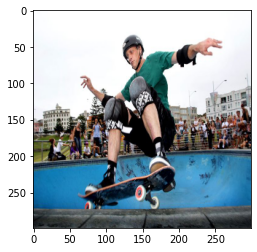

In [26]:
plt.imshow(img)

In [27]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5., sample=True)[1:-1]))

a r g e <UNK> w o m a n <UNK> i s <UNK> s t a n d i n g <UNK> o n <UNK> a <UNK> s k a t e b o a r d <UNK> o n <UNK> a <UNK> s k a t e b o a r d <UNK> . . . <UNK> <UNK> o v e r <UNK> . <UNK> " <UNK> . <UNK> " <UNK> w i n d o w <UNK> . . <UNK> <UNK> r a i l <UNK> . . <UNK> r i d e r <UNK> .
a r g e <UNK> w o m a n <UNK> w i t h <UNK> a <UNK> b l u e <UNK> s k a t e b o a r d <UNK> i n <UNK> t h e <UNK> a i r <UNK> . <UNK> " <UNK> . <UNK> " <UNK> w i n d o w <UNK> . . <UNK> <UNK> u r b a n <UNK> s t r e e t <UNK> . <UNK> " <UNK> . <UNK> " <UNK> w i n d o w <UNK> . . <UNK> <UNK> r a i
a r g e <UNK> b o y <UNK> i s <UNK> s k a t e b o a r d i n g <UNK> d o w n <UNK> a <UNK> s n o w <UNK> c o v e r e d <UNK> s l o p e <UNK> . . <UNK> <UNK> r a i l <UNK> . . <UNK> r e s i d e n t <UNK> . . . <UNK> " <UNK> . <UNK> " <UNK> . <UNK> " <UNK> w h i t e <UNK> t i l e <UNK> .
a r g e <UNK> w o m a n <UNK> i s <UNK> s t a n d i n g <UNK> o n <UNK> a <UNK> s k a t e b o a r d <UNK> o n <UNK> a <UNK> s 

In [28]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img1.jpg
img = plt.imread('img1.jpg')
img = cv2.resize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2022-02-13 09:13:27--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2022-02-13 09:13:27--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img1.jpg’

img1.jpg            100%[===================>] 104.37K   525KB/s    in 0.2s    

2022-02-13 09:13:28 (525 KB/s) - ‘img1.jpg’ saved [106870/106870]



o m a n <UNK> w i t h <UNK> a <UNK> b l a c k <UNK> c a t <UNK> s i t t i n g <UNK> o n <UNK> t h e <UNK> g r o u n d <UNK> . . <UNK> <UNK> u p <UNK> . . <UNK> <UNK> u p <UNK> . . <UNK> r e s t <UNK> . <UNK> . <UNK> . <UNK> s e a t <UNK> . . <UNK> r e s t <UNK> . <UNK> a <UNK> p i c t u r e <UNK> . .
o m a n <UNK> w i t h <UNK> a <UNK> b a t h r o o m <UNK> w i t h <UNK> a <UNK> b e d <UNK> w i t h <UNK> a <UNK> c o m p u t e r <UNK> m o n i t o r <UNK> . <UNK> a <UNK> p i c t u r e <UNK> . <UNK> t h e <UNK> c a m e r a <UNK> . . <UNK> r e s t <UNK> . <UNK> t h e <UNK> c a k e
o m <UNK> c u t t i n g <UNK> a <UNK> b a b y <UNK> l a y i n g <UNK> o n <UNK> a <UNK> b e d <UNK> . . <UNK> <UNK> u p <UNK> . . <UNK> r e s t <UNK> . . . <UNK> <UNK> o m e <UNK> b o t t l e s <UNK> . . . <UNK> <UNK> u p <UNK> . <UNK> t y p e <UNK> . . <UNK> r e s t <UNK> . <UNK> a <UNK> p i c t u r
o m a n <UNK> w i t h <UNK> a <UNK> b a s e b a l l <UNK> g l o v e <UNK> a n d <UNK> a <UNK> b l a c k <UNK> b e 

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

--2022-02-13 09:13:39--  https://www.tensorflow.org/tutorials/text/image_captioning_files/output_9Psd1quzaAWg_2.png
Resolving www.tensorflow.org (www.tensorflow.org)... 142.250.31.100, 142.250.31.102, 142.250.31.138, ...
Connecting to www.tensorflow.org (www.tensorflow.org)|142.250.31.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 462356 (452K) [image/png]
Saving to: ‘img2.jpg’

img2.jpg            100%[===================>] 451.52K  --.-KB/s    in 0.1s    

2022-02-13 09:13:39 (3.55 MB/s) - ‘img2.jpg’ saved [462356/462356]



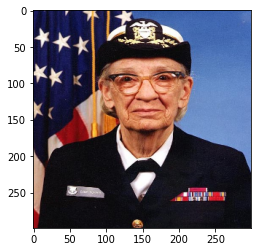

<UNK> p e r s o n <UNK> s t a n d i n g <UNK> n e x t <UNK> t o <UNK> a <UNK> b l u e <UNK> b e d <UNK> . <UNK> t h e <UNK> b a l l o o n <UNK> . <UNK> t h e <UNK> b u i l d i n g <UNK> . . <UNK> r e s t <UNK> . <UNK> a <UNK> p i c t u r e <UNK> . . <UNK> r e s t <UNK> . <UNK> . <UNK> t y
<UNK> p e o p l e <UNK> a r e <UNK> s t a n d i n g <UNK> n e x t <UNK> t o <UNK> a <UNK> b u i l d i n g <UNK> . . <UNK> r e s t <UNK> . <UNK> a <UNK> p i c t u r e <UNK> . . <UNK> <UNK> u r i n a l <UNK> . . . <UNK> <UNK> u p <UNK> . <UNK> . <UNK> . <UNK> s e a t <UNK> . <UNK> . <UNK> . <UNK> s t a
<UNK> p e r s o n <UNK> s t a n d i n g <UNK> i n <UNK> a <UNK> b e d <UNK> w i t h <UNK> a <UNK> c a t <UNK> l a y i n g <UNK> o n <UNK> a <UNK> c o u c h <UNK> . . <UNK> <UNK> u p <UNK> . . <UNK> r e s t <UNK> . <UNK> a <UNK> p i c t u r e <UNK> . . <UNK> <UNK> u r i n a l <UNK> . . . <UNK> <UNK> u
<UNK> p e r s o n <UNK> s t a n d i n g <UNK> i n <UNK> f r o n t <UNK> o f <UNK> a <UNK> b u i l d i n g 

In [29]:
# apply your network on images you've found
!wget https://www.tensorflow.org/tutorials/text/image_captioning_files/output_9Psd1quzaAWg_2.png -O img2.jpg

img = plt.imread('img2.jpg')
img = cv2.resize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

## Бонус: Achtung

В качестве бонусного задания предлагается реализовать механизм attention в rnn-сети, которую мы писали в базовой части.